The sketches in 2b were too simplified, without features like eyes the frogs come out as blobs of frogskin and only occasionally add eyes in appropriate locations.

In this notebook we make a 3rd dataset using U2Net to remove background as in 2b. The sketches have less internal detail than 2. but more than 2b. The result should be a set of sketches which are a bit more detailed than a simple human sketch, but enough to generate more convincing frogs.

In [1]:
from IPython import get_ipython
get_ipython().run_line_magic('reload_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('matplotlib', 'inline')

In [6]:
import os
import random
import zipfile
import shutil
import cv2
import skimage
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image as Img
from IPython.display import display
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from src.config import PATH, DATA_DIR, get_dexined_inference_args
from src.data.create_sketches import run_dexined

# Images with background removed using U2Net
IMAGES_DIR = DATA_DIR / 'processed' / 'targets'
SKETCH_DIR = DATA_DIR / 'processed' / 'sketches'
DEXINED_OUTPUT_DIR = DATA_DIR/'interim'/"DexiNed(U-2-Net masked Images)"

Take the DexiNed outputs from first dataset. Then mask using the U2NET masks.

## DexiNed on Background Removed Images

In [7]:
# get dexined args
dexined_args = get_dexined_inference_args()

# put a few UNET2 examples to test in a folder

# update for this specific case - file paths should be strings
## a few examples in a folder to test
dexined_args.update(dict(
    test_dir=IMAGES_DIR,
    output_dir=DEXINED_OUTPUT_DIR,
    checkpoint_dir=PATH.parent/"src"/"DexiNed_TF2",
    checkpoint="DexiNed23_model.h5",
    test_bs=16,
))

## test on a small sample
# run_dexined(dexined_args)

saved: c:\Users\ylene\Documents\Work\Projects\sketch2frog\sketch2frog\data\interim\DexiNed(U-2-Net masked Images)\DexiNed-BIPED2CLASSIC\h5\frog-1.h5 (8, 224, 224, 1)
saved: c:\Users\ylene\Documents\Work\Projects\sketch2frog\sketch2frog\data\interim\DexiNed(U-2-Net masked Images)\DexiNed-BIPED2CLASSIC\h5\frog-10.h5 (8, 224, 224, 1)
saved: c:\Users\ylene\Documents\Work\Projects\sketch2frog\sketch2frog\data\interim\DexiNed(U-2-Net masked Images)\DexiNed-BIPED2CLASSIC\h5\frog-100.h5 (8, 224, 224, 1)
saved: c:\Users\ylene\Documents\Work\Projects\sketch2frog\sketch2frog\data\interim\DexiNed(U-2-Net masked Images)\DexiNed-BIPED2CLASSIC\h5\frog-1000.h5 (8, 224, 224, 1)
saved: c:\Users\ylene\Documents\Work\Projects\sketch2frog\sketch2frog\data\interim\DexiNed(U-2-Net masked Images)\DexiNed-BIPED2CLASSIC\h5\frog-1001.h5 (8, 224, 224, 1)
saved: c:\Users\ylene\Documents\Work\Projects\sketch2frog\sketch2frog\data\interim\DexiNed(U-2-Net masked Images)\DexiNed-BIPED2CLASSIC\h5\frog-1002.h5 (8, 224, 

Move all "fuse" files to the top directory and delete the rest.

## Find threshold for DexiNed output

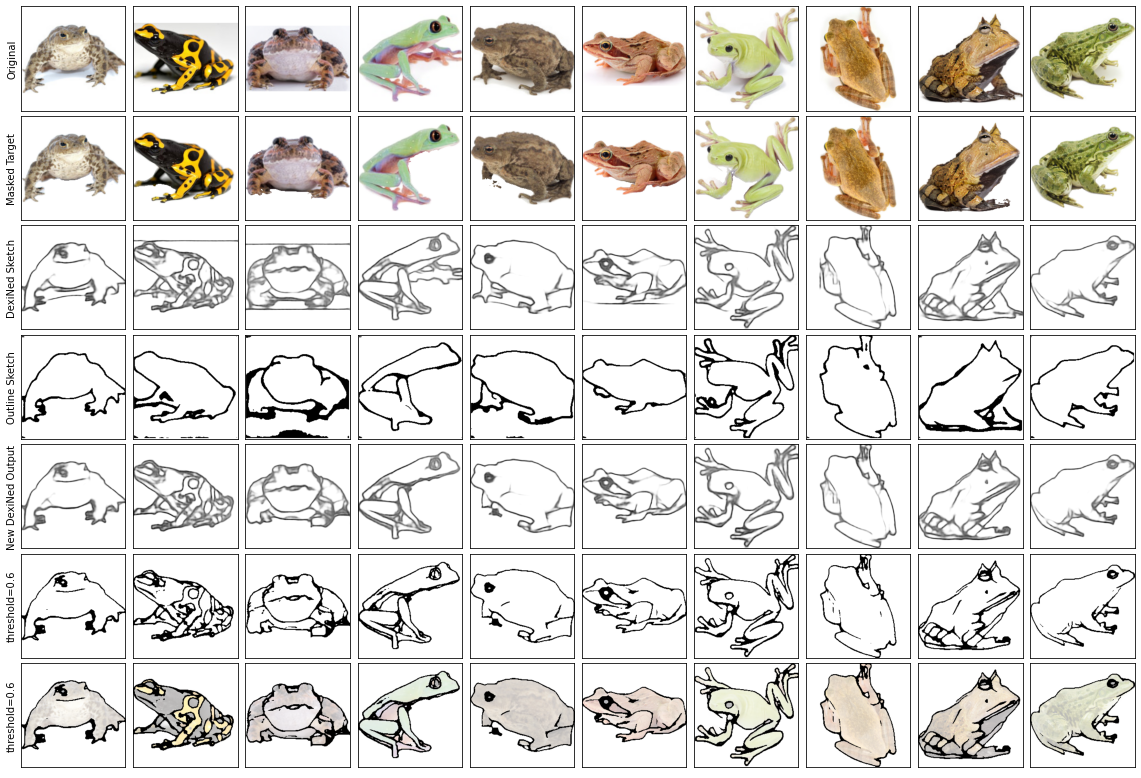

In [28]:
def print_threshold_examples(n=3, thresholds=[0.25, 0.5, 0.75], size=2):
    """
    Prints many approaches to creating sketches from the source images
    """
    rows = 5 + len(thresholds)*2
    
    # prepare figure
    fig, axs = plt.subplots(rows, n, figsize=(size*n, size*rows))
    
    # get frog image names - only look in sample
    fpaths = random.sample(list(DEXINED_OUTPUT_DIR.glob('*.png')), n)
    
    # each column is a new example
    for col, fpath in enumerate(fpaths):
        
        # original image
        original_fpath = DATA_DIR / 'raw' / 'data-224' / fpath.name
        # get source(x)
        target_fpath = IMAGES_DIR / fpath.name
        # get dexined(x)
        dexi_fpath = DATA_DIR / 'interim' / 'DexiNed-fuse' / fpath.name
        # get dexined(unet(x)) path
        outline_sketch_fpath = DATA_DIR / 'processed' / 'outline_sketches' / fpath.name
        # DexiNed(U-2-Net masked Images)
        sketch_fpath = DATA_DIR/'interim'/"DexiNed(U-2-Net masked Images)" / fpath.name
            
        ########  target and past sketches  ########
        original_image = plt.imread(original_fpath)
        axs[0,col].imshow(original_image)
        target_image = plt.imread(target_fpath)
        axs[1,col].imshow(target_image)
        dexi_sketch = plt.imread(dexi_fpath)
        axs[2,col].imshow(dexi_sketch, cmap='gray') # first "sketch"
        outline_sketch = plt.imread(outline_sketch_fpath)
        axs[3,col].imshow(outline_sketch, cmap='gray') # second "sketch"
        new_sketch = plt.imread(sketch_fpath)
        axs[4,col].imshow(new_sketch, cmap='gray') # third "sketch"

        ########  thresholds  ########

        for i, threshold in enumerate(thresholds):
            mask = new_sketch.copy()
            mask[mask < threshold] = 0
            mask[mask >= threshold] = 1
            mask = -mask+1
            
            # initialise masked image
            masked_img = target_image.copy()
            masked_img = np.concatenate(
                [masked_img,
                 np.ones((masked_img.shape[0], masked_img.shape[1], 1))],
                axis=-1)
            
            # where the mask is zero, set the masked image's rgb values to 0
            masked_img[:,:,:3] = np.where(
                mask[:,:,np.newaxis]==1, np.zeros_like(masked_img[:,:,:3]), masked_img[:,:,:3])
            # set the opacity alpha to full (1) everywhere
            masked_img[:,:,-1] = np.ones_like(mask)

            axs[i*2+5,col].imshow(mask, cmap='gray_r')
            axs[i*2+1+5,col].imshow(mask, cmap='gray_r')
            axs[i*2+1+5,col].imshow(masked_img, cmap='gray', alpha=0.3)

    for ax in matplotlib.cbook.flatten(axs):
        ax.set(xticks=[], yticks=[])
        
    # set titles
    axs[0,0].set_ylabel('Original')
    axs[1,0].set_ylabel('Masked Target')
    axs[2,0].set_ylabel('DexiNed Sketch')
    axs[3,0].set_ylabel(f'Outline Sketch')
    axs[4,0].set_ylabel(f'New DexiNed Output')
    for i, threshold in enumerate(thresholds):
        axs[i*2+5,0].set_ylabel(f'threshold={threshold}')
        axs[i*2+1+5,0].set_ylabel(f'threshold={threshold}')

    fig.patch.set_facecolor('white')      
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()
    plt.close()
     
print_threshold_examples(n=10, thresholds=[0.6], size=2)

Using UNet successfully removes any background which can produce horizontal "border" lines through DexiNed.

Using a threshold of 0.6 the final image has much more internal structure than the outline sketches. This should produce much better images, although these new sketches are significantly more detailed than a hand drawn sketch.

## Save New Sketch Dataset

In [35]:
def save_processed_sketch(fpath, save_dir, threshold):
    # load a dexined - unet sketch
    sketch = plt.imread(fpath)

    # apply the threshold for b&w binary
    sketch[sketch <  threshold] = 0
    sketch[sketch >= threshold] = 1
        
    # same format as current sketches for convenience
    sketch = sketch.astype(np.uint8) * 255

    # save to processed folder
    save_path = save_dir/fpath.name
    cv2.imwrite(str(save_path), sketch)

SKETCH_THRESHOLD = 0.6

# apply this function to every image in the directory
for fpath in DEXINED_OUTPUT_DIR.glob("*.png"):
    save_processed_sketch(fpath, SKETCH_DIR, SKETCH_THRESHOLD)